In [1]:
import os
import sys

sys.path.append("/home/pkarpov/Sapsan")

from sapsan.lib.backends import MLflowBackend
from sapsan.lib.data import HDF5Dataset, EquidistantSampling, flatten
#from sapsan.lib.estimator.cnn.cnn3d_estimator import CNN3d, CNN3dConfig
from sapsan.lib import Train, Evaluate

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from IPython import display
import numpy as np
%matplotlib inline


def plot_params():
    params = {'font.size': 14, 'legend.fontsize': 14, 
              'axes.labelsize': 20, 'axes.titlesize':24,
              'xtick.labelsize': 17,'ytick.labelsize': 17,
              'axes.linewidth': 1, 'patch.linewidth': 3, 'lines.linewidth': 3,
              'xtick.major.width': 1.5,'ytick.major.width': 1.5,
              'xtick.minor.width': 1.25,'ytick.minor.width': 1.25,
              'xtick.major.size': 7,'ytick.major.size': 7,
              'xtick.minor.size': 4,'ytick.minor.size': 4,
              'xtick.direction': 'in','ytick.direction': 'in',              
              'axes.formatter.limits' : [-7, 7], 
              'axes.grid':True, 'grid.linestyle': ':', 'grid.color':'#999999',
              'text.usetex': False}              
    return params

class shock:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.shock_i = 0
        self.shock_r = 0
        
    def plot_plt(self, label=0, title='', shock=False, log='loglog', refresh=True, **kwargs):
        style = 'tableau-colorblind10'
        mpl.style.use(style)
        mpl.rcParams.update(plot_params())   

        plt.figure(figsize=(10,6))
        plt.gca().cla() 
        if log=='loglog': plt.loglog(self.x, self.y, label=label)
        elif log=='semilog': plt.semilogx(self.x, self.y, label=label)
        else: plt.plot(self.x, self.y, label=label)
            
        self.shock_position_rev()
        plt.axvline(self.shock_r, color='tab:red', label='shock')
        
        plt.legend(loc=3)
        
        if 'xmin' in kwargs: xmin = kwargs['xmin']
        if 'xmax' in kwargs: xmax = kwargs['xmax']; plt.xlim(xmin, xmax)
        if 'ymin' in kwargs: ymin = kwargs['ymin']
        if 'ymax' in kwargs: ymax = kwargs['ymax']; plt.ylim(ymin, ymax)
        
        plt.xlabel('r')
        plt.ylabel('Velocity')
        plt.title(title)
        if refresh:
            display.clear_output(wait=True)
            display.display(plt.gcf()) 
        return plt
    
    def shock_position_rev(self):    
        self.shock_r = 0
        '''
        for i in range(len(self.y)-1,0,-1):
            if i==len(self.y)-1: initial = self.y[-1]
            else:
                if self.y[i]<(initial-(initial-min(self.y))*0.1):
                    old_max = self.y[i]
                    for j in range(i-1,0,-1):
                        if self.y[j] <= old_max:
                            old_max = self.y[j]
                        else:                        
                            self.shock_r=self.x[j]
                            self.shock_i=j                          
                            break
                    break
        '''
        self.shock_i=np.argmin(self.y)
        self.shock_r = self.x[self.shock_i]
        print('shock position rev: %.2e'%self.shock_r, self.shock_i)

In [3]:
def process_var(var, v, new_r, shock_i):
    f = interpolate.interp1d(np.arange(len(v))[:shock_i+1], var[:shock_i+1])
    return f(new_r)

def interp_var(x, y, interp):
    x_interp = np.zeros((x.shape[0], x.shape[1], interp))
    y_interp = np.zeros((y.shape[0], y.shape[1], interp))
    for i in range(x.shape[0]):
        v = x[i,0]
        sh = shock(np.arange(len(v)), v)
        sh.shock_position_rev()
        print(sh.shock_i, sh.shock_r)
        new_r = np.linspace(0,sh.shock_i,interp)

        y_interp[i,0] = process_var(y[i,0], v, new_r, sh.shock_i)        
        
        for j in range(x.shape[1]): 
            x_interp[i,j] = process_var(x[i,j], v, new_r, sh.shock_i)

    return x_interp, y_interp, sh.shock_i

In [4]:
# Resolution: 678x128x256 (r x theta x phi): r, pi and 2pi respectively
# outter radius is 2e4 km (2e9 cm)

#comp0: Ye
#eos0: gas pressure
#eos1: sound speed
#eos2: Temperature
#eos3: entropy
#eos4: gamma_1
#The rad variables of relevance are Erad0, Erad1, Erad2 (0, 1, 2 corresponding to electron neutrinos, electron anti-neutrinos, and heavy neutrinos) energy densitivies, and analgously for Frad0,1,2.

#['Flux0_0', 'Flux0_1', 'Flux0_2', 'Flux1_0', 'Flux1_1', 'Flux1_2', 
#'Flux2_0', 'Flux2_1', 'Flux2_2', 'Pturb_s2', 'Time', 'comp0', 
#'eos0', 'eos1', 'eos2', 'eos3', 'eos4', 
#'lapse', 'lapse_edge', 'rho', 'u', 'u1', 'u2', 'u3', 
#'velocity0', 'velocity1', 'velocity2']

#path = "data/t{checkpoint:1.0f}/{feature}_dim32_fm15.h5"
base = '/home/pkarpov/scratch/adam/s19.0.swbj15.horo.3d/'

path = base+"dump_{checkpoint:05d}.h5"

features_label = ['u1','rho','comp0','eos0', 'eos1', 'eos2', 'eos3']
target_label = ['Pturb_s2']
#target_label = ['u1']
target = ['dummy']

INPUT_SIZE = [678]

In [5]:
from scipy import interpolate
checkpoints = [10,20,30,40,50,60,70,80,90,100,
               110,120,130,140,150,160,170]#,180,
               #190,200,210,220,230,240,250,260,
               #270,280,290,300]
checkpoints = [210]
'''
grid = HDF5Dataset(path= base+'grid.h5',
                          features_label=['volume'],
                          checkpoints=[0],
                          input_size=INPUT_SIZE)
vol = grid.load_numpy().flatten()
'''
grid = HDF5Dataset(path= base+'grid.h5',
                          features_label=['Z'],
                          checkpoints=[0],
                          input_size=INPUT_SIZE)
r = grid.load_numpy().flatten()[:-1]

data_loader = HDF5Dataset(path=path,                        
                          features_label=['Time'],                          
                          checkpoints=checkpoints,
                          input_size=INPUT_SIZE,                          
                          shuffle = False,
                          train_fraction = len(checkpoints)-1)
time = data_loader.load_numpy()[0,0,0]

#Load the data
data_loader = HDF5Dataset(path=path,
                          target=target,
                          features_label=features_label,
                          target_label=target_label,
                          checkpoints=checkpoints,
                          input_size=INPUT_SIZE,
                          #sampler=sampler,
                          shuffle = False,
                          train_fraction = len(checkpoints)-1)

x, y = data_loader.load_numpy()
interp = 200
print('shapes', x.shape,y.shape)

#x[:,3] = x[:,3]/2e22
#y[:,0] = y[:,0]/2e22
#print(x[0,1,:])
#print(y[1,0,:])
#sys.exit()

x_interp, y_interp, shock_i = interp_var(x, y, interp)
loaders = data_loader.convert_to_torch([x_interp, y_interp])

print('Time %.2f ms'%(time*1e3))

Features:  ['None']
Fetures_label: ['Z']
Loading 'Z' from file '/home/pkarpov/scratch/adam/s19.0.swbj15.horo.3d/grid.h5'
----------
Features:  ['None']
Fetures_label: ['Time']
Loading 'Time' from file '/home/pkarpov/scratch/adam/s19.0.swbj15.horo.3d/dump_00210.h5'
----------
Features:  ['None']
Fetures_label: ['u1', 'rho', 'comp0', 'eos0', 'eos1', 'eos2', 'eos3']
Loading 'u1' from file '/home/pkarpov/scratch/adam/s19.0.swbj15.horo.3d/dump_00210.h5'
----------
Loading 'rho' from file '/home/pkarpov/scratch/adam/s19.0.swbj15.horo.3d/dump_00210.h5'
----------
Loading 'comp0' from file '/home/pkarpov/scratch/adam/s19.0.swbj15.horo.3d/dump_00210.h5'
----------
Loading 'eos0' from file '/home/pkarpov/scratch/adam/s19.0.swbj15.horo.3d/dump_00210.h5'
----------
Loading 'eos1' from file '/home/pkarpov/scratch/adam/s19.0.swbj15.horo.3d/dump_00210.h5'
----------
Loading 'eos2' from file '/home/pkarpov/scratch/adam/s19.0.swbj15.horo.3d/dump_00210.h5'
----------
Loading 'eos3' from file '/home/pkar

In [ ]:
%matplotlib inline
from sapsan.utils.plot import line_plot

file1d = '/home/pkarpov/1dccsn/project/1dmlmix/output/DataOut_s19.0_readable.88'
with open(file1d, "r") as file:
    line = file.readline()
    time1d = file.readline()

print('Time %.2f ms'%(float(time1d)*1e3))

ps = np.loadtxt(file1d, skiprows=3)
ps = np.moveaxis(ps,0,1)
print(ps.shape)
print(x_interp.shape)
print('%.2e %.2e'%(ps[-1,504], r[200]*1e5))
print('%.2e'%(ps[-1,0]))
#print('edge of NS %.2e'%(r[30]*1e5))
ax = line_plot([[ps[2], ps[-1]],
                [ps[2,:504]*1e0, ps[-1,:504]],
                [r*1e5, x[0,5]*1e9],
                [r[:200]*1e5, x_interp[0,5]*1e9]],
               plot_type='loglog', 
               label=['1d', 'before shock 1d', 
                      '3d','before shock 3d'],
               linestyle=['-','--','-','--'],               
               figsize=(10,6))
#ax.axvline(x=r[20]*1e5,linestyle='-',color='r',linewidth=1)
ax.set_xlabel('Radius [cm]')
#ax.set_ylabel(r'$\rho \; [\frac{g}{cm^3}]$')
ax.set_ylabel(r'Temperature $[K]$')
ax.set_title('$t_{1d}=$%.2f ms, $t_{3d}=$%.2f ms'%(float(time1d)*1e3, time*1e3))

plt.tight_layout()
#plt.savefig('/home/pkarpov/scratch/plots/temperature.png')

In [6]:
#vs. radius
#%matplotlib inline
%matplotlib auto
from sapsan.utils.plot import line_plot
#Cell M_enclosed Position Rho V Ye Pressure Temperature
numfiles = 400#2284
lumnue = np.zeros((numfiles))
times = np.zeros((numfiles))

for i in range(226,numfiles):  
#for i in range(300,numfiles):  
    #i = 300
    #file1d = '/home/pkarpov/1dccsn/project/1dmlmix/output/s19.0_hr/DataOut_s19.0_hr_readable.%d'%(i+1)
    file1d = '/home/pkarpov/1dccsn/project/1dmlmix/output/s19.0_run4/DataOut_s19.0_readable.%d'%(i+1)
    with open(file1d, "r") as file:
        line = file.readline()        
        vals = file.readline()
        vals_strip = vals[:-1].split(' ')        
        time1d, shock_ind, shock_r, rlumnue = [float(x) for x in vals_strip if x!='']   
        lumnue[i] = rlumnue
        times[i] = time1d    
        #print(file.readline())
        #sys.exit()

    print('Time %.2f ms'%(float(time1d)*1e3))
    #continue

    ps = np.loadtxt(file1d, skiprows=3)
    ps = np.moveaxis(ps,0,1)
    
    shock_ind = np.argmin(ps[4])

    ps_ind = 3
    ax = line_plot([[ps[2]*1e-5, ps[ps_ind]],],
                    #[ps[2,:504]*1e0, ps[ps_ind,:504]],                    
                   #plot_type='semilogy',
                   plot_type='loglog',
                   label = [f'ind {i+1}'],
                   linestyle=['-','--','-','--'],               
                   figsize=(10,6))    
    if float(time1d) >= 0.2397:
        edgerho = 2e11
        edger=0
        lenrho = len(ps[ps_ind])-1
        for j in range(lenrho):
            if ps[ps_ind,lenrho-j]>edgerho:
                edgeenc = ps[1,lenrho-j]
                edger = ps[2,lenrho-j]
                break
        print('shock', ps[1,int(shock_ind)])
        #ax.axvline(x=edgeenc,linestyle='-',color='r',linewidth=1, label = 'PNS %.3f $M_{sol}$'%edgeenc)
        ax.axvline(x=edger*1e-5,linestyle='-',color='r',linewidth=1, 
                   label = 'PNS    %.2e km'%(edger*1e-5))
        ax.axvline(x=ps[2,int(shock_ind)]*1e-5,linestyle='--',color='r',
                   linewidth=2, label = 'shock %.2e km'%(ps[2,int(shock_ind)]*1e-5))
    #ax.set_xlabel(r'$M_{enc} \; [M_{sol}]$')
    #ax.set_xlabel(r'$Radius \; [cm]$')
    ax.set_xlabel(r'$Radius \; [km]$')
    #ax.set_ylabel(r'$P_{gas} \; [\frac{g}{cm\;s^2}]$')
    #ax.set_ylabel(r'Velocity $[cm/s]$')
    ax.set_ylabel(r'Density $[g/cm^3]$')
    ax.set_title('$t_{1d}=$%.2f ms'%(float(time1d)*1e3))
    #ax.set_xlim((0,3)) #M_enc
    #ax.set_ylim((-5e9, 1.5e9)) #velocity
    #ax.set_xlim((1e4,1e10)) #radius in cm
    ax.set_xlim((1e0,1e5)) #radius in km
    #ax.set_xlim((0,4)) #M_enc 2
    #ax.set_ylim((1e20,1e36)) #pressure
    ax.set_ylim((1e4,1e15)) #density

    plt.legend()
    plt.tight_layout()
    plt.savefig('/home/pkarpov/scratch/plots/s19.0/density/rho_r%d.png'%(i+1))
    plt.close()
    #break#if i == 255: break

Using matplotlib backend: agg
Time 239.56 ms
Time 240.56 ms
shock 1.2473
Time 241.56 ms
shock 1.3122
Time 242.56 ms
shock 1.3623
Time 243.56 ms
shock 1.4016
Time 244.56 ms
shock 1.4367
Time 245.56 ms
shock 1.4722
Time 246.56 ms
shock 1.5034
Time 247.56 ms
shock 1.5278
Time 248.56 ms
shock 1.5449
Time 249.56 ms
shock 1.5573
Time 250.56 ms
shock 1.5672
Time 251.56 ms
shock 1.5772
Time 252.56 ms
shock 1.5847
Time 253.56 ms
shock 1.5948
Time 254.56 ms
shock 1.5999
Time 255.56 ms
shock 1.6075
Time 256.56 ms
shock 1.6126
Time 257.56 ms
shock 1.6151
Time 258.56 ms
shock 1.6202
Time 259.56 ms
shock 1.6228
Time 260.57 ms
shock 1.6253
Time 261.57 ms
shock 1.6305
Time 262.57 ms
shock 1.6305
Time 263.57 ms
shock 1.633
Time 264.57 ms
shock 1.633
Time 265.57 ms
shock 1.6356
Time 266.57 ms
shock 1.6356
Time 267.57 ms
shock 1.6356
Time 268.57 ms
shock 1.6382
Time 269.57 ms
shock 1.6382
Time 270.57 ms
shock 1.6382
Time 271.57 ms
shock 1.6408
Time 272.57 ms
shock 1.6408
Time 273.57 ms
shock 1.6408
Time 

FileNotFoundError: [Errno 2] No such file or directory: '/home/pkarpov/1dccsn/project/1dmlmix/output/s19.0_run4/DataOut_s19.0_readable.397'

In [11]:
#vs. Enclosed Mass
#%matplotlib inline
%matplotlib auto
from sapsan.utils.plot import line_plot
#Cell M_enclosed Position Rho V Ye Pressure Temperature
numfiles = 400#2284
lumnue = np.zeros((numfiles))
times = np.zeros((numfiles))

#for i in range(226,numfiles):  
for i in range(numfiles):  
    #file1d = '/home/pkarpov/1dccsn/project/1dmlmix/output/s19.0_hr/DataOut_s19.0_hr_readable.%d'%(i+1)
    file1d = '/home/pkarpov/1dccsn/project/1dmlmix/output/s19.0_run4/DataOut_s19.0_readable.%d'%(i+1)
    with open(file1d, "r") as file:
        line = file.readline()        
        vals = file.readline()
        vals_strip = vals[:-1].split(' ')        
        time1d, shock_ind, shock_r, rlumnue = [float(x) for x in vals_strip if x!='']   
        lumnue[i] = rlumnue
        times[i] = time1d    
        #print(file.readline())
        #sys.exit()

    print('Time %.2f ms'%(float(time1d)*1e3))
    #continue

    ps = np.loadtxt(file1d, skiprows=3)
    ps = np.moveaxis(ps,0,1)
    
    shock_ind = np.argmin(ps[4])

    ps_ind = 3
    ax = line_plot([[ps[1], ps[ps_ind]],],
                    #[ps[2,:504]*1e0, ps[ps_ind,:504]],                    
                   plot_type='semilogy',
                   #plot_type='loglog',
                   label = [f'ind {i+1}'],
                   linestyle=['-','--','-','--'],               
                   figsize=(10,6))    
    if float(time1d) >= 0.2397:
        edgerho = 2e11
        edger=0
        lenrho = len(ps[ps_ind])-1
        for j in range(lenrho):
            if ps[ps_ind,lenrho-j]>edgerho:
                edgeenc = ps[1,lenrho-j]
                edger = ps[2,lenrho-j]
                break
        print('shock', ps[1,int(shock_ind)])
        ax.axvline(x=edgeenc,linestyle='-',color='r',linewidth=1, label = 'PNS %.3f $M_{sol}$'%edgeenc)
        #ax.axvline(x=edger*1e-5,linestyle='-',color='r',linewidth=1, 
        #           label = 'PNS    %.2e km'%(edger*1e-5))
        ax.axvline(x=ps[1,int(shock_ind)],linestyle='--',color='r',
                   linewidth=2, label = 'shock %.3f $M_{sol}$'%(ps[1,int(shock_ind)]))
    ax.set_xlabel(r'$M_{enc} \; [M_{sol}]$')
    #ax.set_xlabel(r'$Radius \; [cm]$')
    #ax.set_xlabel(r'$Radius \; [km]$')
    #ax.set_ylabel(r'$P_{gas} \; [\frac{g}{cm\;s^2}]$')
    #ax.set_ylabel(r'Velocity $[cm/s]$')
    ax.set_ylabel(r'Density $[g/cm^3]$')
    ax.set_title('$t_{1d}=$%.2f ms'%(float(time1d)*1e3))
    ax.set_xlim((0,3)) #M_enc
    #ax.set_ylim((-5e9, 1.5e9)) #velocity
    #ax.set_xlim((1e4,1e10)) #radius in cm
    #ax.set_xlim((1e0,1e5)) #radius in km
    #ax.set_xlim((0,4)) #M_enc 2
    #ax.set_ylim((1e20,1e36)) #pressure
    ax.set_ylim((1e4,1e15)) #density

    plt.legend()
    plt.tight_layout()
    plt.savefig('/home/pkarpov/scratch/plots/s19.0/density/rho_encm%d.png'%(i+1))
    plt.close()
    #break#if i == 255: break

Using matplotlib backend: agg
Time 1.10 ms
Time 2.17 ms
Time 3.22 ms
Time 4.26 ms
Time 5.31 ms
Time 6.49 ms
Time 7.50 ms
Time 8.53 ms
Time 9.53 ms
Time 10.70 ms
Time 11.84 ms
Time 12.96 ms
Time 14.09 ms
Time 15.22 ms
Time 16.32 ms
Time 17.42 ms
Time 18.52 ms
Time 19.62 ms
Time 20.72 ms
Time 21.82 ms
Time 22.91 ms
Time 24.00 ms
Time 25.09 ms
Time 26.17 ms
Time 27.25 ms
Time 28.33 ms
Time 29.42 ms
Time 30.49 ms
Time 31.56 ms
Time 32.64 ms
Time 33.70 ms
Time 34.78 ms
Time 35.84 ms
Time 36.90 ms
Time 37.95 ms
Time 39.04 ms
Time 40.10 ms
Time 41.16 ms
Time 42.20 ms
Time 43.27 ms
Time 44.35 ms
Time 45.40 ms
Time 46.45 ms
Time 47.50 ms
Time 48.61 ms
Time 49.63 ms
Time 50.65 ms
Time 51.66 ms
Time 52.69 ms
Time 53.71 ms
Time 54.74 ms
Time 55.77 ms
Time 56.77 ms
Time 57.79 ms
Time 58.81 ms
Time 59.84 ms
Time 60.96 ms
Time 61.98 ms
Time 63.10 ms
Time 64.12 ms
Time 65.23 ms
Time 66.37 ms
Time 67.50 ms
Time 68.62 ms
Time 69.74 ms
Time 70.86 ms
Time 71.97 ms
Time 73.08 ms
Time 74.18 ms
Time 75.29 ms

FileNotFoundError: [Errno 2] No such file or directory: '/home/pkarpov/1dccsn/project/1dmlmix/output/s19.0_run4/DataOut_s19.0_readable.397'

0.021064 0.77005
2255


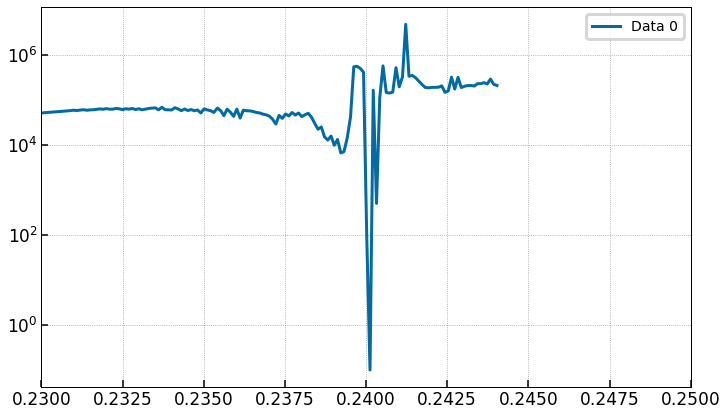

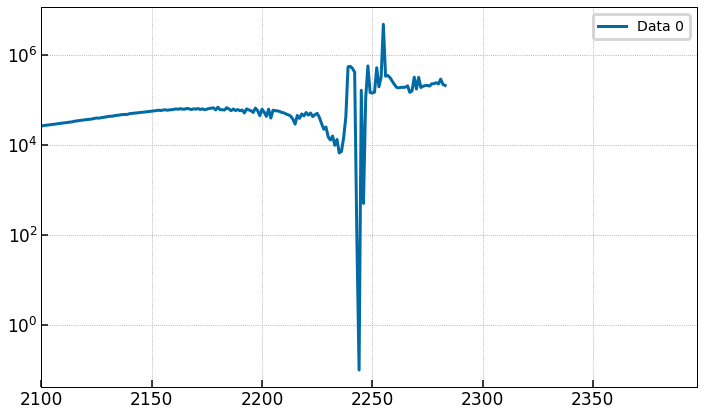

In [122]:
%matplotlib inline
ind = 200
print(times[ind], lumnue[ind])
ax = line_plot([[times, lumnue]], figsize=(10,6),
              plot_type='semilogy')
ax.set_xlim(0.23,0.25)

ax = line_plot([[range(numfiles), lumnue]], figsize=(10,6),
              plot_type='semilogy')
ax.set_xlim(2100)
print(np.argmax(lumnue))

0.21341 3801.8
228


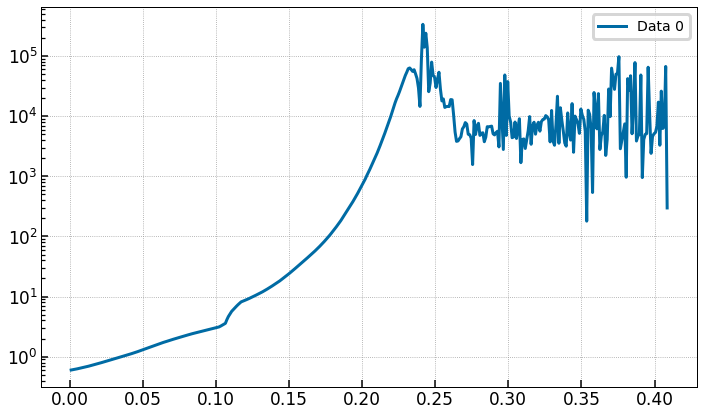

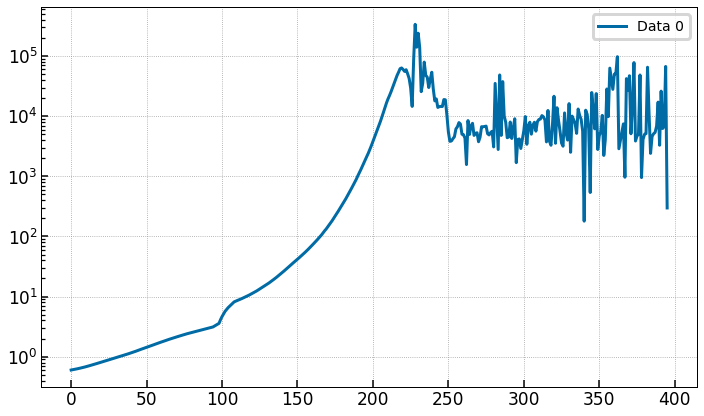

In [115]:
%matplotlib inline
ind = 200
print(times[ind], lumnue[ind])
ax = line_plot([[times, lumnue]], figsize=(10,6),
              plot_type='semilogy')
ax = line_plot([[range(numfiles), lumnue]], figsize=(10,6),
              plot_type='semilogy')
print(np.argmax(lumnue))

Time 412.58 ms
(8, 1668)
(1, 7, 200)
2.21e+06 1.78e+07
7.89e+04
Max 2.47e+34


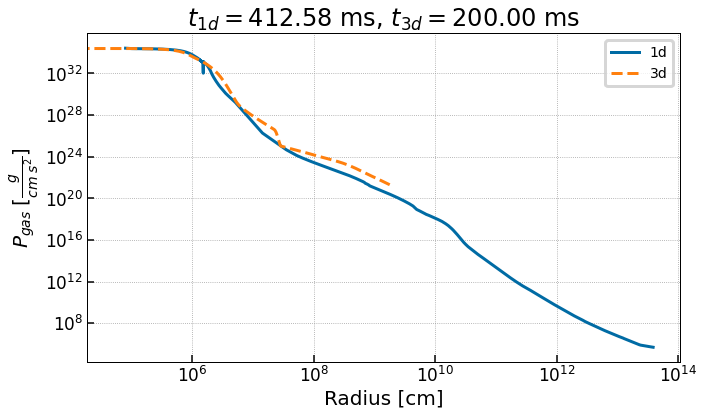

In [111]:
%matplotlib inline
#Cell M_enclosed Position Rho V Ye Pressure Temperature

from sapsan.utils.plot import line_plot

file1d = '/home/pkarpov/1dccsn/project/1dmlmix/output/s19.0_run2/DataOut_s19.0_readable.400'
with open(file1d, "r") as file:
    line = file.readline()
    time1d = file.readline()

print('Time %.2f ms'%(float(time1d)*1e3))

ps = np.loadtxt(file1d, skiprows=3)
ps = np.moveaxis(ps,0,1)
print(ps.shape)
#print(ps[2])
#print(r[:10]*1e5)
print(x_interp.shape)
#+ps[2,0]
#plt.loglog(range(ps.shape[1]), ps[-1])
#plt.loglog(range(x.shape[-1]), x[0,3])
print('%.2e %.2e'%(ps[2,504], r[200]*1e5))
print('%.2e'%(ps[2,0]))

print('Max %.2e'%max(x[0,3]))

ps_ind = 6
x_ind = 3
ax = line_plot([[ps[2], ps[ps_ind]],
                #[ps[2,:504], ps[ps_ind,:504]],
                [r*1e5, x[0,x_ind]],],
                #[r[:200]*1e5, x_interp[0,x_ind]]],
               plot_type='loglog', 
               label=['1d',# 'before shock 1d', 
                      '3d','before shock 3d'],
               linestyle=['-','--','-','--'],
               figsize=(10,6))
#ax.axvline(x=r[20]*1e5,linestyle='-',color='r',linewidth=1,label='~$r_{pns}$ for 3d')

plt.legend()
ax.set_xlabel('Radius [cm]')
ax.set_ylabel(r'$P_{gas} \; [\frac{g}{cm\; s^2}]$')
ax.set_title('$t_{1d}=$%.2f ms, $t_{3d}=$%.2f ms'%(float(time1d)*1e3, time*1e3))
#ax.set_xlim((1e6,1e10))
#ax.set_ylim((1e20,1e34))


plt.tight_layout()
#plt.savefig('/home/pkarpov/scratch/plots/Pgas1d3d_post_collapse.png')

/home/pkarpov/scratch/adam/s19.0.swbj15.horo.3d/
<KeysViewHDF5 ['Flux0_0', 'Flux0_1', 'Flux0_2', 'Flux1_0', 'Flux1_1', 'Flux1_2', 'Flux2_0', 'Flux2_1', 'Flux2_2', 'Pturb_s2', 'Time', 'comp0', 'eos0', 'eos1', 'eos2', 'eos3', 'eos4', 'lapse', 'lapse_edge', 'rho', 'u', 'u1', 'u2', 'u3', 'velocity0', 'velocity1', 'velocity2']>
0.17557836457737366
[1.22130643e+10 1.21804617e+10 1.21213725e+10 1.20330813e+10
 1.19151686e+10]
[-8772388.578125    1083298.1875      2311098.51319885  3769803.03640747
  5551987.61142731]


SystemExit: 

/home/pkarpov/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3426: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


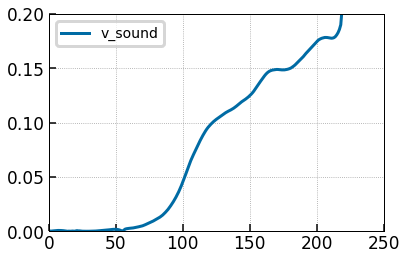

In [188]:
# %matplotlib inline
import h5py as h5
print(base)
#with (h5.File(base+'grid.h5', 'r')) as hf:
with (h5.File(base+"dump_00200.h5", 'r')) as hf:
    print(hf.keys()) 
    vs = np.array(hf['eos1'])
    u1 = np.array(hf['u1'])

    print(abs(u1)[201]/vs[201])
    print(vs[:5])
    print(u1[:5])
    plt.plot(range(len(vs)),abs(u1)/vs, label='v_sound')
    #plt.plot(range(len(vs)),vs, label='v_sound')
    #plt.plot(range(len(vs)),abs(u1), label='v')
    plt.legend()
    #plt.ylim(0,0.25e10)
    plt.ylim(0,0.2)
    plt.xlim(0,250)
    
    sys.exit()
    z = hf['Z']
    ind = list(z.shape)[0]
    plt.figure(figsize=(10,6))
    plt.plot(range(ind),z,marker='o', label='z')
    plt.legend()
    
    #for i in range(ind-1):
    #    print(i, z[i+1]-z[i])

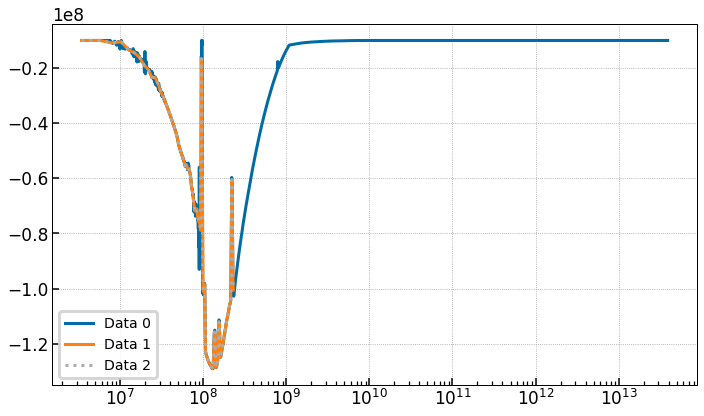

In [31]:
# Checking how well the linear grid interpolation works in Fortran

%matplotlib inline
base = '/home/pkarpov/1dccsn/project/1dmlmix/'
original = np.loadtxt(base+'output/s19.0_run1/DataOut_s19.0_readable.7', skiprows=3)
x_normed = np.loadtxt(base+'tmpdir/normed/x_7.txt')
x_interp = np.loadtxt(base+'tmpdir/x_7.txt')

v_normed = np.loadtxt(base+'tmpdir/normed/v_7.txt')
v_interp = np.loadtxt(base+'tmpdir/v_7.txt')

x = original[:,2]
v = original[:,4]

ax = line_plot([[x, v],
                [x_interp, v_interp],
                [x_normed, v_normed]],
               linestyle = ['-', '-', ':'],
               plot_type='semilogx',
               figsize = (10,6))

In [77]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from IPython import display
import numpy as np

def plot_params():
    params = {'font.size': 14, 'legend.fontsize': 14, 
              'axes.labelsize': 20, 'axes.titlesize':24,
              'xtick.labelsize': 17,'ytick.labelsize': 17,
              'axes.linewidth': 1, 'patch.linewidth': 3, 'lines.linewidth': 3,
              'xtick.major.width': 1.5,'ytick.major.width': 1.5,
              'xtick.minor.width': 1.25,'ytick.minor.width': 1.25,
              'xtick.major.size': 7,'ytick.major.size': 7,
              'xtick.minor.size': 4,'ytick.minor.size': 4,
              'xtick.direction': 'in','ytick.direction': 'in',              
              'axes.formatter.limits' : [-7, 7], 
              'axes.grid':True, 'grid.linestyle': ':', 'grid.color':'#999999',
              'text.usetex': False}              
    return params

class shock:
    def __init__(self, x, y, vsound):
        self.x = x
        self.y = y
        self.vsound = vsound
        self.shock_i = 0
        self.shock_r = 0
        
    def plot_shock(self, label=0, title='', shock=False, log=None, refresh=False, **kwargs):
        style = 'tableau-colorblind10'
        mpl.style.use(style)
        mpl.rcParams.update(plot_params())   

        plt.figure(figsize=(10,6))
        plt.gca().cla() 
        if log=='loglog': plt.loglog(self.x, self.y, label=label)
        elif log=='semilog': plt.semilogx(self.x, self.y, label=label)
        else: plt.plot(self.x, self.y, label=label)
            
        self.shock_position()
        plt.axvline(self.shock_r, color='tab:red', label='shock')
        
        plt.legend(loc=3)
        
        if 'xmin' in kwargs: xmin = kwargs['xmin']
        if 'xmax' in kwargs: xmax = kwargs['xmax']; plt.xlim(xmin, xmax)
        if 'ymin' in kwargs: ymin = kwargs['ymin']
        if 'ymax' in kwargs: ymax = kwargs['ymax']; plt.ylim(ymin, ymax)
        
        plt.xlabel('r')
        plt.ylabel('Velocity')
        plt.title(title)
        if refresh:
            display.clear_output(wait=True)
            display.display(plt.gcf()) 
        return plt
    
    def shock_position(self):    
        self.shock_r = 0
        self.shock_i=np.argmin(self.y)
        self.shock_r = self.x[self.shock_i]
        
        # mach = abs(self.y/self.vsound)
        # oldmax = -1
        # for i in range(np.argmin(self.y),-1,-1):
        #     if mach[i] < 1:
        #         oldslope = abs((mach[i+1]-mach[i])/(self.x[i+1]-self.x[i]))
        #         newslope = abs((mach[i]-mach[i-1])/(self.x[i]-self.x[i-1]))
        #         self.shock_i = i
        #         self.shock_r = self.x[self.shock_i]
        #         break
                # if newslope<0.7*oldslope:
                #     print('slopes', oldslope, newslope)
                #     self.shock_i = i
                #     self.shock_r = self.x[self.shock_i]   
                #     break     
        
        #print('shock position: %.2e'%self.shock_r, self.shock_i)
        return self.shock_i
        
def pns_radius(rho, rho_threshold=5e10):    
    for i in range(len(rho)-1,-1,-1):
        if rho[i] >= rho_threshold:
            pns_x = rho[i]
            pns_ind = i
            break
    return pns_ind

<KeysViewHDF5 ['X', 'Y', 'Z', 'area0', 'area1', 'area2', 'gcov0', 'gcov1', 'gcov2', 'mask', 'volume']>
6.108380464710216
5.96440801949278
5.624897274136549
5.00423811881602
3.9956930459637725
2.982283598028526
2.146242392102982
1.4472912975538266
0.9125977788833832
ind 198
150 46 198
Mt > 1.0:  6


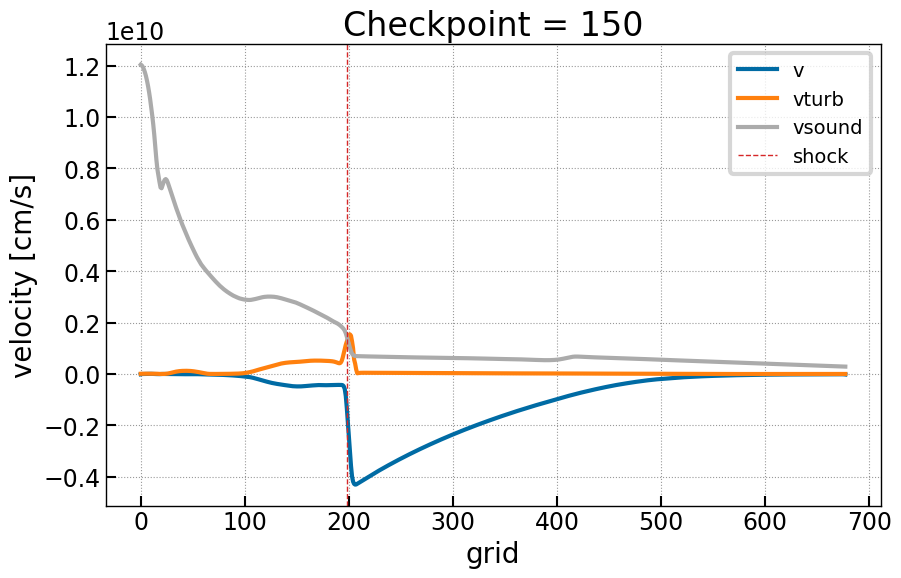

In [32]:
base_path = '/home/pkarpov/scratch/adam'
dataset = 's20.0.swbj15.horo.3d'

versus = 'mach'
versus = 'r'

if versus == 'r':
    path = f'{base_path}/{dataset}/grid.h5'
    with (h5.File(path, 'r')) as hf:
        print(hf.keys())
        r = np.array(hf['Z'])    

for ind in range(296):
    ind=150
    path = f'{base_path}/{dataset}/dump_{ind:05d}.h5'

    with (h5.File(path, 'r')) as hf:
        #print(hf.keys())
        v = np.array(hf['u1'])
        vsound = np.array(hf['eos1'])
        rho = np.array(hf['rho'])
        
    pns_ind = pns_radius(rho, rho_threshold=1e13)
    sh = shock(np.arange(len(v)), v, vsound)
        
    shock_ind = sh.shock_position()
    print('ind', shock_ind)
    #sh.plot_shock(refresh=False, log=None)#ymin=1e-10,ymax=1e8)
 
    val_names = ['u1', 'eos1', 'eos0', 'Pturb_s2', 'rho']
    #all_vals = np.zeros((len(val_names), shock_ind-pns_ind))
    all_vals = np.zeros((len(val_names), len(v)))

    with (h5.File(path, 'r')) as hf:
        for i in range(len(val_names)):
            all_vals[i] = np.array(hf[val_names[i]])#[pns_ind:shock_ind]
        

    print(ind, pns_ind, shock_ind)

    v = all_vals[0]
    vsound = all_vals[1]
    p = all_vals[2]
    pturb = all_vals[3]
    rho = all_vals[4]
  
    vturb = np.sqrt(3*pturb/rho)
    Mt = (vturb/vsound)
        
    counter = 0
    shock_lim = 1
    for i in range(len(v)):
        if vturb[i]/vsound[i] > shock_lim: counter +=1
        
    print('Mt > %.1f: '%shock_lim, counter)
    
    plt.figure(figsize=(10,6))
    plt.plot(np.arange(len(v)), v, label='v')    
    plt.plot(np.arange(len(v)), vturb, label='vturb')
    plt.plot(np.arange(len(v)), vsound, label='vsound')
    plt.axvline(shock_ind, linewidth = 1, linestyle='--',color='tab:red', label='shock')
    plt.ylabel('velocity [cm/s]')
    plt.xlabel('grid')
    plt.title(f"Checkpoint = {ind}")
    
    plt.legend()
    
    break

Power Spectrum has been calculated. k and E(k) have been returned.


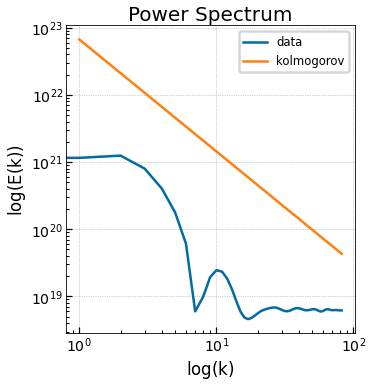

In [240]:
import os
import sys

sys.path.append("../../../")

from sapsan.lib.backends import MLflowBackend
from sapsan.lib.data import HDF5Dataset, EquidistantSampling, flatten
#from sapsan.lib.estimator.cnn.cnn3d_estimator import CNN3d, CNN3dConfig
from sapsan.lib import Train, Evaluate

import h5py as h5
import numpy as np
from sapsan.utils import PowerSpectrum

path = '/home/pkarpov/scratch/adam/s20.0.swbj15.horo.3d/dump_00230.h5'
    
with (h5.File(path, 'r')) as hf:
    #print(hf.keys())
    v = np.array(hf['u1'])
    rho = np.array(hf['rho'])
    
pns_ind = pns_radius(rho, rho_threshold=1e13)
sh = shock(np.arange(len(v)), v)
shock_ind = sh.shock_position()    

vel = np.array([v[pns_ind:shock_ind]])
ps = PowerSpectrum(vel)

k_bins, Ek_bins = ps.calculate()
splt = ps.spectrum_plot(k_bins,Ek_bins)

In [81]:
import os
import sys

sys.path.append("/home/pkarpov/Sapsan")

from sapsan.lib.backends import MLflowBackend
from sapsan.lib.data import HDF5Dataset, EquidistantSampling, flatten
#from sapsan.lib.estimator.cnn.cnn3d_estimator import CNN3d, CNN3dConfig
from sapsan.lib import Train, Evaluate
from sapsan.utils import line_plot

import h5py as h5
import numpy as np
#from sapsan.utils import PowerSpectrum

#comp0: Ye
#eos0: gas pressure
#eos1: sound speed
#eos2: Temperature
#eos3: entropy
#eos4: gamma_1
#The rad variables of relevance are Erad0, Erad1, Erad2 (0, 1, 2 corresponding to electron neutrinos, electron anti-neutrinos, and heavy neutrinos) energy densitivies, and analgously for Frad0,1,2.
    
ind = 200
base_path = '/home/pkarpov/scratch/adam'
dataset = 's20.0.swbj15.horo.3d'

versus = 'mach'

versus = 'r'
mach_type = 'v' # 'v' or 'vturb'

if versus == 'r':
    path = f'{base_path}/{dataset}/grid.h5'
    with (h5.File(path, 'r')) as hf:
        print(hf.keys())
        r = np.array(hf['Z'])    

for ind in range(296):
    ind=280
    path = f'{base_path}/{dataset}/dump_{ind:05d}.h5'

    with (h5.File(path, 'r')) as hf:
        #print(hf.keys())
        v = np.array(hf['u1'])
        vsound = np.array(hf['eos1'])
        rho = np.array(hf['rho'])
        
    pns_ind = pns_radius(rho, rho_threshold=1e13)
    sh = shock(np.arange(len(v)), v, vsound)
        
    shock_ind = sh.shock_position()
    print('ind', shock_ind)
    #sh.plot_shock(refresh=False)#ymin=1e-10,ymax=1e8)
    #sys.exit()

    val_names = ['u1', 'eos1', 'eos0', 'Pturb_s2', 'rho']
    #all_vals = np.zeros((len(val_names), shock_ind-pns_ind))
    all_vals = np.zeros((len(val_names), len(v)))

    with (h5.File(path, 'r')) as hf:
        for i in range(len(val_names)):
            all_vals[i] = np.array(hf[val_names[i]])
        

    print(ind, pns_ind, shock_ind)

    v      = all_vals[0]
    vsound = all_vals[1]
    p      = all_vals[2]
    pturb  = all_vals[3]
    rho    = all_vals[4]
  
    vturb = np.sqrt(3*pturb/rho)
    Mt = abs(vturb/vsound)
    M = abs(v/vsound)            
    
    if versus == 'mach':
        
        yrel = (pturb/p)**2
        xrel = Mt
            
        fig = plt.figure(figsize=(10,6))            
        ax = fig.add_subplot(111)        
        ax.scatter(xrel[pns_ind:shock_ind],yrel[pns_ind:shock_ind], 
                   marker='o',linewidth=1,facecolors='none', edgecolors='tab:blue')
        
        xlim = [3e-2, 2e0]  
        gamma = 4/3
        slope = (gamma**2)/9
        linx = np.linspace(xlim[0], xlim[1], 100)
        liny = slope*linx**4
        ax.loglog(linx,liny, color='tab:red', linewidth=1, linestyle = '--', label='$\gamma^2M_t^4/\,9$ with $\gamma=4/3$')
        ax.set_ylim(1e-5, 1e0)
        ax.set_xlim(xlim[0],xlim[1])
        #ax.set_ylim(0, 0.7)    
        ax.set_ylabel('$(P_{turb}/P_{gas})^2$')
        ax.set_xlabel('$M_t=v_{turb}/v_{sound}$')
        save_name = f'{versus}_{ind}.png'
        
    elif versus == 'r':
            
        if mach_type == 'v': 
            yrel = M
            ylabel = '$M=v/v_{sound}$'
            save_name = f'M_{versus}_{ind}.png'
        elif mach_type == 'vturb': 
            yrel = Mt
            ylabel = '$M_t=v_{turb}/v_{sound}$' 
            save_name = f'Mt_{versus}_{ind}.png'           
        xrel = r[1:]
        print('mach', max(yrel))
        sys.exit()

        #ax.scatter(xrel,yrel, marker='o',linewidth=1,facecolors='none', edgecolors='tab:blue')
        ax = line_plot([[xrel,yrel],
                        [xrel[pns_ind:shock_ind],yrel[pns_ind:shock_ind]]], 
                       linestyle=['-','--'], label=['Full', 'Convection'],figsize=(10,6))        
        #ax.set_ylim(1e-5, 1e0)
        ax.set_xlim(0, 275)
        ax.set_ylim(0, 1.1)    
        ax.set_xlabel('$Radius \; [km]$')
        ax.set_ylabel(ylabel)
        ax.get_legend().remove()
        
    else: sys.exit('Unknown versus parameter')
        
    #ax.set_xlabel('$(V/V_{sound})^2$')
    ax.set_title(f'Checkpoint = {ind}')
    # ax.get_legend().remove() 
    plt.legend(loc=2)
    plt.tight_layout()

    # ax = line_plot([[vsound,(p/rho)**(1/2)]], 
    #             plot_type='plot')
    
    
    save_path = f'{base_path}/{dataset}/plots/mach_lim_slope0.7'
    plt.savefig(f'{save_path}/{save_name}')
    plt.close()
    
# ax = line_plot([[ind,xrel]])
# ax.set_ylabel('$(\overline{V}/V_{sound})^2$')
# ax.set_xlabel('index')

# ax = line_plot([[ind,yrel]])
# ax.set_ylabel('$P_{turb}/P_{gas}$')
# ax.set_xlabel('index')
    
# path = '/home/pkarpov/scratch/adam/s19.0.swbj15.horo.3d/grid.h5'

# with (h5.File(path, 'r')) as hf:
#     print(hf.keys())
#     r = np.array(hf['Z'])

# ps = PowerSpectrum(vel)

<KeysViewHDF5 ['X', 'Y', 'Z', 'area0', 'area1', 'area2', 'gcov0', 'gcov1', 'gcov2', 'mask', 'volume']>
ind 238
280 47 238
mach 4.471150127974059


SystemExit: 

/home/pkarpov/anaconda3/envs/py310/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3386: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


<KeysViewHDF5 ['Flux0_0', 'Flux0_1', 'Flux0_2', 'Flux1_0', 'Flux1_1', 'Flux1_2', 'Flux2_0', 'Flux2_1', 'Flux2_2', 'Pturb_s2', 'Time', 'comp0', 'eos0', 'eos1', 'eos2', 'eos3', 'eos4', 'lapse', 'lapse_edge', 'rho', 'u', 'u1', 'u2', 'u3', 'velocity0', 'velocity1', 'velocity2']>
(678,)


<AxesSubplot:>

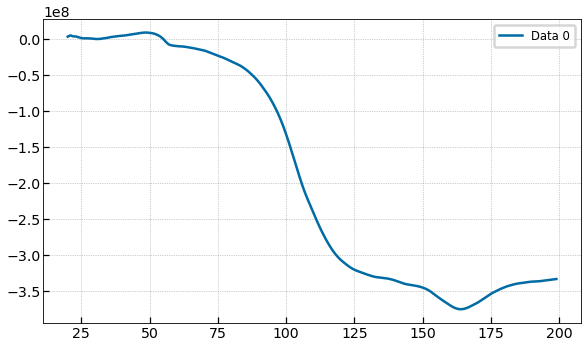

In [71]:
from sapsan.utils import line_plot
import h5py as h5
import numpy as np

path = '/home/pkarpov/scratch/adam/s19.0.swbj15.horo.3d/dump_00200.h5'

with (h5.File(path, 'r')) as hf:
    print(hf.keys())
    u = np.array(hf['u'])
    u1 = np.array(hf['u1'])
    u2 = np.array(hf['u2'])
    u3 = np.array(hf['u3'])
    
x = np.arange(u.shape[0])
sh = x.shape[0]
print(x.shape)

line_plot([[x[20:200],u1[20:200]],
           #[x,np.sqrt(u1**2+u2**2+u3**2)]
           ],          
          figsize=(10,6))